In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
%matplotlib inline

plt.style.use('seaborn-whitegrid')
import pandas as pd

/tmp/ipykernel_755302/3903320903.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [2]:
from util import get_files, parse_filename
import numpy as np

TYPE = 'peps'
directory = f'results/{TYPE}'
SHOULD_AGGREGATE = True
DELTA = 5
THETA = 18 if TYPE == 'peps' else 30
IS_TTN = False if TYPE == 'peps' else True
FONT_SIZE = 22

def parse_result_file(file):
  # Optimization:
  # iks: 2.00 ms
  # greedy: 2.00 ms
  # dpccp: 2.00 ms
  # lindp-iks: 2.00 ms

  # Contraction:
  # iks: 1.00 ms
  # greedy: 1.00 ms
  # dpccp: 1.00 ms
  # lindp-iks: 1.00 ms

  # Speedups:
  # iks: 95572266.86713023867694042473
  # greedy: 39353068.83343006384213580963
  # dpccp: 96023419.93957703927492447130
  # lindp-iks: 96023419.93957703927492447130

  def parseBlock(f):
    d = {'name' : None, 'content' : {}}
    while True:
      line = f.readline().strip()
      if not line:
        return d

      split = line.split(':')
      if len(split) == 1 or (not split[1]):
        d['name'] = split[0]
      else:
        d['content'][split[0]] = split[1].strip()

  with open(file, 'r') as f:
    info = []
    for _ in range(4):
      info.append(parseBlock(f))
    return info

def parse_files(files):
  def explain(class_, v):
    if class_ in ['Optimization', 'Contraction', 'Costs']:
      return float(v.split(' ')[0])
    elif class_ == 'Speedup':
      return np.log10(float(v))

  ret = []
  def update_dict(file, block):
    class_ = block['name']
    info = parse_filename(file)

    curr_size = info['size']
    if SHOULD_AGGREGATE:
      if curr_size > THETA:
        import math
        curr_size = int(math.ceil(curr_size / DELTA) * DELTA)

    for algo, val in block['content'].items():
      mydict = None
      if 'qsim' in info:
        mydict = {'class' : class_, 'leg' : 'closed', 'size' : curr_size, 'optimizer' : algo, 'value' : explain(class_, val)}
      else:
        mydict = {'class' : class_, 'leg' : info['leg'], 'size' : curr_size, 'optimizer' : algo, 'value' : explain(class_, val)}  
      ret.append(mydict)

  for file in files:
    info = parse_result_file(f'{directory}/{file}')
    for block in info:
      # print(block)
      update_dict(file, block)
  return ret

ds = parse_files(get_files(directory))
print(ds[0])
df = pd.DataFrame(ds)

optimizations = df[df['class'] == 'Optimization']
costs = df[df['class'] == 'Costs']

# Put log10
# costs['value'] = costs['value'].apply(lambda x: np.log10(x))

def agg_data(data):
  data = data.groupby(['class', 'leg', 'optimizer', 'size'], as_index=False).agg({'value': 'mean'})
  data = data.sort_values(by=['class', 'leg', 'optimizer', 'size'], ignore_index=True)

agg_data(optimizations)
agg_data(costs)

# Reset log10
# costs['value'] = costs['value'].apply(lambda x: 10**x)

costs

{'class': 'Optimization', 'leg': 'open', 'size': 125, 'optimizer': 'custom-random-greedy', 'value': 438.0}


,class,leg,size,optimizer,value
4,Costs,open,125,lindp-parallel,6.854298e+40
5,Costs,open,125,greedy,1.963648e+42
6,Costs,open,125,custom-random-greedy,1.963648e+42
7,Costs,open,125,tensor-ikkbz-parallel,4.473046e+47
12,Costs,closed,410,custom-random-greedy,5.526839e+12
...,...,...,...,...,...
6527,Costs,open,215,tensor-ikkbz-parallel,8.568320e+66
6532,Costs,closed,130,custom-random-greedy,8.059185e+09
6533,Costs,closed,130,lindp-parallel,1.918984e+10
6534,Costs,closed,130,greedy,4.801958e+10


In [3]:
markers = ["o", "o", "o", "s", "s", "s", "P", "P", "P", "<", "<", "<"]
mycolors = ["tab:blue", "tab:red", "tab:purple", "tab:green", "tab:cyan", "tab:olive" ]

# Order of the algorithm in the label.
translate = {
  "tensor-ikkbz-parallel" : "TensorIKKBZ",
  "lindp-parallel" : "LinDP",
  "idp-parallel" : "IDP[LinDP]",
  "custom-random-greedy" : "oe.RandomGreedy",
  "greedy" : "oe.Greedy",
  "dpccp" : "DPccp",
  "dp" : "oe.DynamicProgramming"
}

result = [ 'TensorIKKBZ', 'LinDP', 'DPccp', 'oe.DynamicProgramming', 'oe.Greedy', 'oe.RandomGreedy']

def setup_colors():
  mysetup = {}
  count = 0
  for elem in result:
    mysetup[elem] = {"color" : mycolors[count], "marker" : markers[count]}
    count += 1
  return mysetup

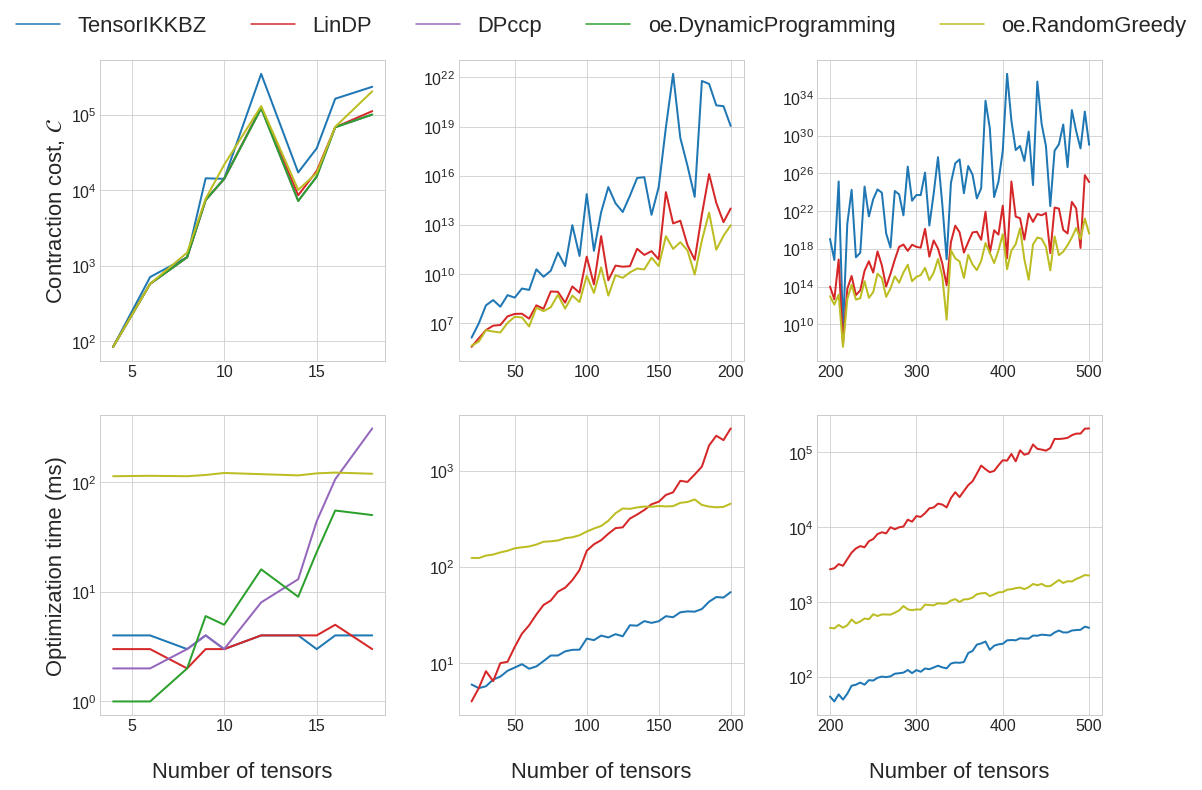

In [6]:
import seaborn as sns

def cleanse(data):
  # Replace algorithms name.
  for key, val in translate.items():
    data = data.replace(to_replace=key, value=val)

  # Remove algorithms we don't want to benchmark right now.
  to_remove = ['IDP[LinDP]', 'oe.Greedy']
  new_result = result.copy()
  for val in to_remove:
    data = data.loc[data["optimizer"] != val]
    for index in range(len(new_result)):
      if new_result[index] == val:
        new_result.pop(index)
        break

  # Update `result`, i.e., the list of algorithms on the legend.
  changed = True
  while changed:
    changed = False
    for index in range(len(new_result)):
      if new_result[index] not in data['optimizer'].unique():
        new_result.pop(index)
        changed = True
        break
  return data, new_result

def setup(data, leg):
  # Cleanse data.
  data[0], new_result = cleanse(data[0])
  data[1], new_result = cleanse(data[1])

  mysetup = setup_colors()
  mycolors = [mysetup[algo]["color"] for algo in new_result]
  customPalette = sns.set_palette(sns.color_palette(mycolors))

  fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10), sharey=False, sharex=False, constrained_layout=False)
  df = [
    data[0].sort_values(by=['size'], ignore_index=True),
    data[1].sort_values(by=['size'], ignore_index=True)
  ]
  
  def compute_lw(data):
    # min_ = data['size'].min()
    # max_ = data['size'].max()
    # if max_ - min_ > 200:
    #   return 1.25
    # else:
    #   return 2.0
    return 2.0
  
  for i in range(2):
    for j in range(3):
      data = df[i]
      if not j:
        data = data.loc[data['size'] <= THETA]
      elif j == 1:
        data = data.loc[data['size'] > THETA]
        data = data.loc[data['size'] <= 200]
      elif j == 2:
        data = data.loc[data['size'] >= 200] 

      # Draw the line.
      ret = sns.lineplot(linewidth=compute_lw(data), ax=axs[i][j], x="size", y="value", hue="optimizer", data=data, errorbar=None, hue_order=new_result, palette=customPalette)
      
      # Set the scale of the y-axis.
      if leg == 'open' and (not i):
        ret.set(yscale='log')
      if i or not IS_TTN:
        ret.set(yscale='log')

  return fig, axs

def plot(data1, data2, leg, ylabels):
  data = [data1, data2]
  data[0] = data[0].loc[data[0]['leg'] == leg]
  data[1] = data[1].loc[data[1]['leg'] == leg]

  def explain_leg(leg):
    if leg == 'closed':
      return 'w/o open legs'
    return 'w/ open legs'

  # Fetch the figure.
  fig, axs = setup(data, leg)
  fig.tight_layout()

  # Put the title.
  # axs[0][1].set_title(label=f'{TYPE.upper()}, {explain_leg(leg)}\n', size=FONT_SIZE)

  for i in range(2):
    for j in range(3):
      # Set xlabel.
      if i:
        axs[i][j].set(xlabel=f'\nNumber of tensors')
      else:
        axs[i][j].xaxis.label.set_visible(False)
      
      # Set ylabel.
      if j:
        axs[i][j].yaxis.label.set_visible(False)
      else:
        axs[i][j].set(ylabel=ylabels[i])

      # Set off the legend.
      axs[i][j].get_legend().set_visible(False)

  # Setup the legend.
  # sns.move_legend(axs[0][2], bbox_to_anchor=(1.025, 1.0), loc=2, borderaxespad=0.0, title=None, fontsize=FONT_SIZE, frameon=False)

  sns.move_legend(
      axs[0][1], "lower center",
      borderaxespad=0.0,
      bbox_to_anchor=(0.5, 1.05),
      ncol=5,
      title=None,
      frameon=False,
      fontsize=FONT_SIZE
  )

  # leg = plt.legend()
  # print(leg.get_lines())
  # for line in leg.get_lines():
  #   line.set_linewidth(100)

  # Set fontsizes.
  plt.rcParams['axes.labelsize'] = FONT_SIZE
  plt.rc('xtick', labelsize=16)
  plt.rc('ytick', labelsize=16)  

  # Save figure.
  plt.savefig(f'figures/{TYPE}-{leg}-full-all.png', bbox_inches='tight', dpi=300)

plot(costs, optimizations, 'closed', [r'Contraction cost, $\mathcal{C}$', r'Optimization time (ms)'])

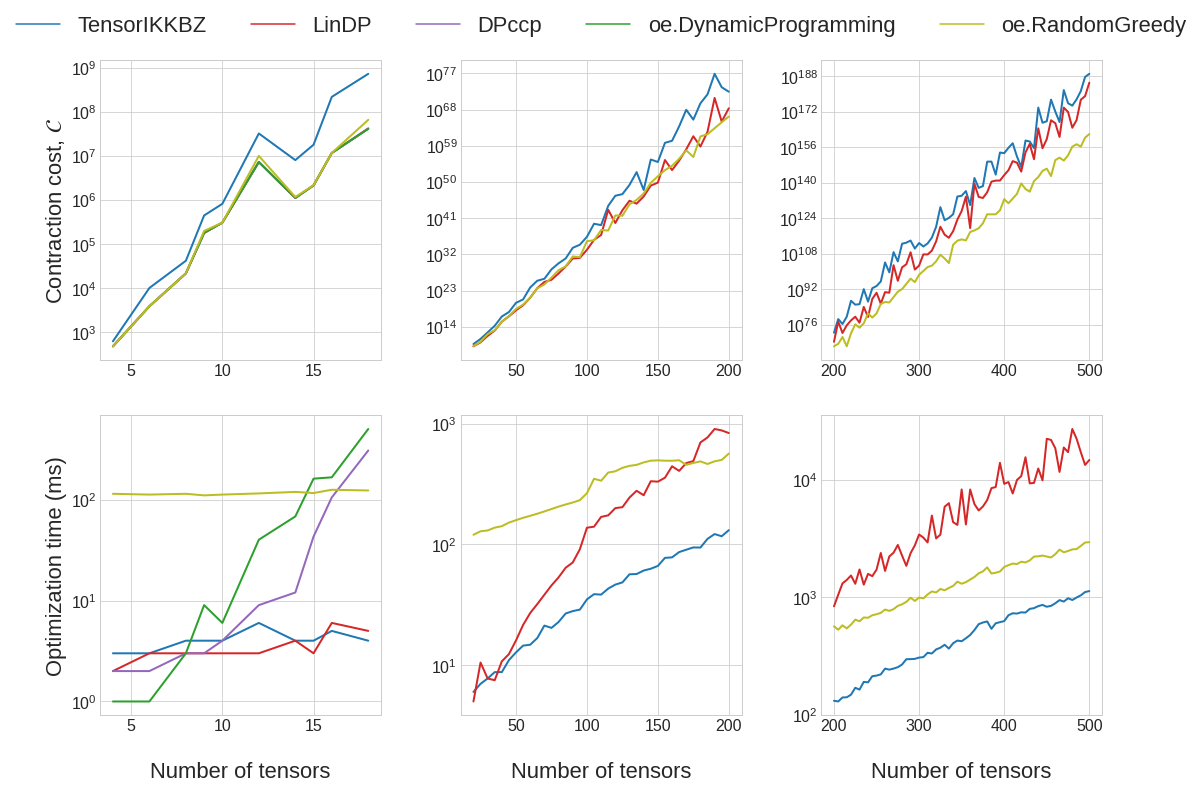

In [5]:
plot(costs, optimizations, 'open', [r'Contraction cost, $\mathcal{C}$', r'Optimization time (ms)'])